In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [41]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 21

In [42]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [43]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [44]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


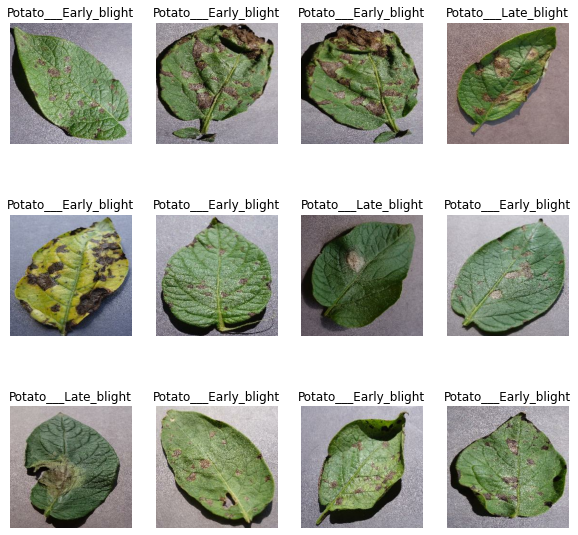

In [45]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [46]:
len(dataset)

68

In [47]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [48]:
train_ds = dataset.take(54)
len(train_ds)

54

In [49]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [50]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [51]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [52]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [53]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [54]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [55]:
len(train_ds)

54

In [56]:
len(val_ds)

6

In [57]:
len(test_ds)

8

In [58]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [59]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [60]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [61]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [64]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=21,
)

Epoch 1/21
54/54 [==============================] - 78s 1s/step - loss: 0.9178 - accuracy: 0.4913 - val_loss: 0.8561 - val_accuracy: 0.5781
Epoch 2/21
54/54 [==============================] - 77s 1s/step - loss: 0.7015 - accuracy: 0.6910 - val_loss: 0.7142 - val_accuracy: 0.6823
Epoch 3/21
54/54 [==============================] - 74s 1s/step - loss: 0.4461 - accuracy: 0.8131 - val_loss: 0.5206 - val_accuracy: 0.7760
Epoch 4/21
54/54 [==============================] - 75s 1s/step - loss: 0.3238 - accuracy: 0.8791 - val_loss: 0.4135 - val_accuracy: 0.8177
Epoch 5/21
54/54 [==============================] - 75s 1s/step - loss: 0.2655 - accuracy: 0.8987 - val_loss: 0.1704 - val_accuracy: 0.9375
Epoch 6/21
54/54 [==============================] - 73s 1s/step - loss: 0.1474 - accuracy: 0.9439 - val_loss: 0.0840 - val_accuracy: 0.9635
Epoch 7/21
54/54 [==============================] - 73s 1s/step - loss: 0.1199 - accuracy: 0.9525 - val_loss: 0.0933 - val_accuracy: 0.9635
Epoch 8/21
54/54 [==

In [77]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 309ms/step - loss: 0.1117 - accuracy: 0.9844


In [78]:
scores

[0.11172940582036972, 0.984375]

In [79]:
history

In [80]:
history.params

{'verbose': 1, 'epochs': 21, 'steps': 54}

In [81]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [82]:
type(history.history['loss'])

list

In [83]:
len(history.history['loss'])

21

In [84]:
history.history['loss'][:5]

[0.9177840352058411,
 0.701498806476593,
 0.44609057903289795,
 0.32382890582084656,
 0.26545393466949463]

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


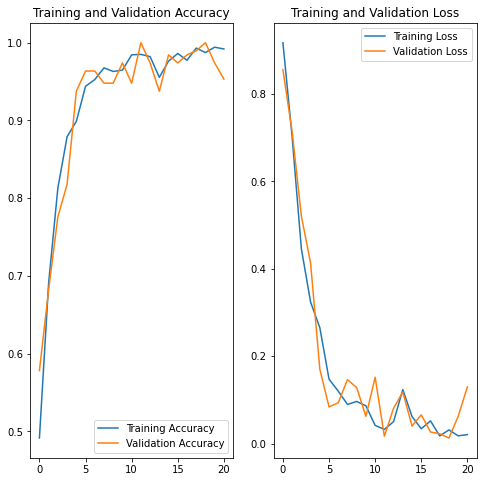

In [86]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 453ms/step
predicted label: Potato___Early_blight


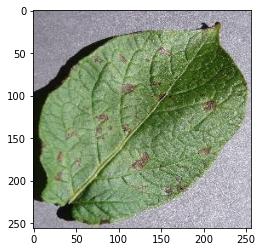

In [97]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [98]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


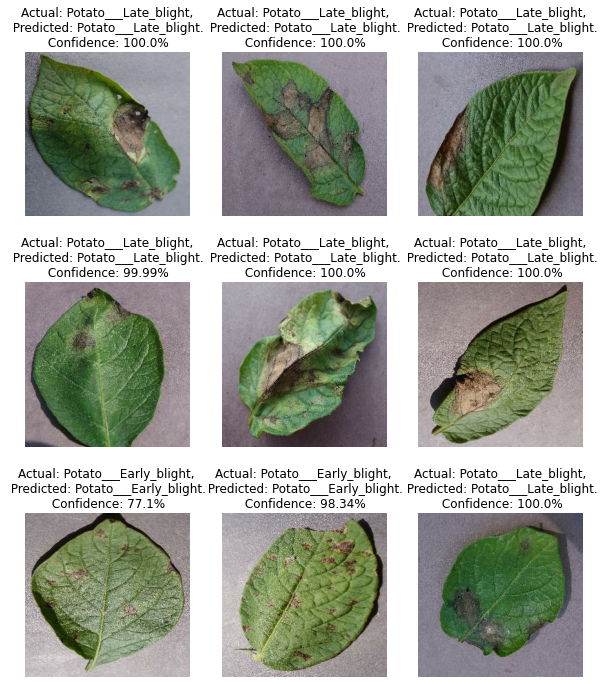

In [102]:
plt.figure(figsize = (10, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [103]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets
